# Cox proportional hazards model

This sub-repository contains the Python notebooks for the tutorial "Survival of the Fittest: Classical and Machine Learning Methods for Time-to-Event Modeling" of D. Meier and A. Sturge for the Data Science Working Group of the Swiss Actuarial Association, see https://actuarialdatascience.org.

Before running this notebook make sure that you have created all datasets by running the two notebooks "IPUMS NHIS Dataset" and "Synthetic Dataset".

In [16]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter
from sklearn.model_selection import train_test_split
from sksurv.metrics import integrated_brier_score
from sksurv.util import Surv
from sklearn.metrics import log_loss
from scipy.special import logit
import time
import sys
import importlib

modules = [
    'polars',
    'pandas',
    'seaborn',
    'matplotlib',
    'numpy',
    'lifelines',
    'sksurv',
    'sklearn',
    'scipy'
]

print(f"Python version: {sys.version}\n")

for module in modules:
    try:
        mod = importlib.import_module(module)
        version = getattr(mod, '__version__', 'built-in or no __version__')
        print(f"{module} version: {version}")
    except ImportError:
        print(f"{module} is not installed.")

sns.set()

Python version: 3.9.21 (main, Dec 11 2024, 10:23:52) 
[Clang 14.0.6 ]

polars version: 1.29.0
pandas version: 1.5.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
numpy version: 1.26.4
lifelines version: 0.26.4
sksurv version: 0.21.0
sklearn version: 1.2.2
scipy version: 1.13.1


In [2]:
df = pl.read_csv("data/prepared_data.csv")
df = df.with_columns(pl.col("earnings_quantile").cast(pl.Float64))
df = df.with_columns(pl.col("HRSLEEP").cast(pl.Int64))
df

AGE,YEAR,BMICALC,SMOKESTATUS2,USBORN,HIPRIVATEE,HRSLEEP,FAMKIDNO,MARSTAT,EDUC,earnings_quantile,time,event,REGION_2,REGION_3,REGION_4,MALE
i64,i64,f64,bool,bool,bool,i64,i64,bool,bool,f64,i64,bool,i64,i64,i64,bool
28,2000,null,false,true,true,null,4,true,false,null,20,false,0,0,0,true
35,2000,29.0,false,true,true,null,4,true,false,null,20,false,0,0,0,false
34,2000,null,false,true,true,null,4,false,false,null,20,false,0,0,0,false
38,2000,null,false,true,true,null,3,true,false,null,20,false,1,0,0,false
46,2000,null,false,true,true,null,3,true,false,null,20,false,1,0,0,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
56,2016,24.0,false,true,true,8,0,false,false,0.931819,20,false,0,0,1,true
58,2016,31.4,false,true,true,6,0,false,true,0.378244,20,false,0,1,0,true
71,2016,25.0,false,false,false,5,0,true,false,0.378274,20,false,0,0,0,false


In [3]:
df.describe(
    percentiles=[0.1, 0.3, 0.5, 0.7, 0.9],
    interpolation="linear",
)

statistic,AGE,YEAR,BMICALC,SMOKESTATUS2,USBORN,HIPRIVATEE,HRSLEEP,FAMKIDNO,MARSTAT,EDUC,earnings_quantile,time,event,REGION_2,REGION_3,REGION_4,MALE
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.017399e6,1.017399e6,452527.0,1.017399e6,1.017399e6,1.017399e6,381309.0,1.017399e6,1.017399e6,1.017399e6,497251.0,1.017399e6,1.017399e6,1.017399e6,1.017399e6,1.017399e6,1.017399e6
"""null_count""",0.0,0.0,564872.0,0.0,0.0,0.0,636090.0,0.0,0.0,0.0,520148.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",46.01009,2007.88259,27.172053,0.097398,0.789782,0.622297,7.329643,0.76755,0.54883,0.251728,0.500008,18.48665,0.118508,0.210176,0.364702,0.253368,0.471176
"""std""",17.612213,4.785579,5.246692,null,null,null,1.875634,1.152579,null,null,0.288675,4.440046,null,0.407434,0.481347,0.43494,null
"""min""",18.0,2000.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000012,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""30%""",34.0,2004.0,24.0,null,null,null,7.0,0.0,null,null,0.300008,20.0,null,0.0,0.0,0.0,null
"""50%""",45.0,2008.0,26.5,null,null,null,7.0,0.0,null,null,0.500008,20.0,null,0.0,0.0,0.0,null
"""70%""",55.0,2011.0,29.2,null,null,null,8.0,1.0,null,null,0.700006,20.0,null,0.0,1.0,0.0,null


In [4]:
dfp = df.to_pandas()
dfp_nn = dfp.dropna()
print(dfp.shape)
print(dfp_nn.shape)

(1017399, 17)
(231717, 17)


Fitting time: 0.95 seconds


<lifelines.CoxPHFitter: fitted with 185373 total observations, 170161 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 185373
number of events observed = 15212
   partial log-likelihood = -168571.82
         time fit was run = 2025-08-24 19:04:40 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
AGE                0.07      1.08      0.00            0.07            0.08                1.08                1.08
BMICALC           -0.20      0.82      0.01           -0.22           -0.17                0.81                0.84
I(BMICALC ** 2)    0.00      1.00      0.00            0.00            0.00                1.00                1.00
SMOKESTATUS2       0.61      1.85      0.02            0.57            0.66                1.77                1.93
USBORN             0.39      1.48      0.03            0.34            0.45                1.40                1.56
HIPRIVATEE        -0.13      0.88      0.02           -0.16           -0.10                0.85                0.91
HRSLEEP           -0.06      0.94      0.02           -0.09           -0.02                0.91                0.98
I(HRSLEEP ** 2)    0.01      1.01      0.00            0.00            0.01                1.00                1.01
FAMKIDNO           0.01      1.01      0.02           -0.02            0.04                0.98                1.04
MARSTAT           -0.32      0.73      0.02           -0.36           -0.29                0.70                0.75
EDUC              -0.21      0.81      0.02           -0.25           -0.17                0.78                0.84
earnings_quantile -1.30      0.27      0.04           -1.38           -1.22                0.25                0.30
REGION_2           0.04      1.04      0.03           -0.01            0.09                0.99                1.10
REGION_3           0.07      1.07      0.02            0.02            0.12                1.02                1.12
REGION_4          -0.03      0.97      0.03           -0.08            0.02                0.92                1.02
MALE               0.51      1.66      0.02            0.47            0.54                1.60                1.71

                   cmp to      z      p  -log2(p)
covariate                                        
AGE                  0.00  96.09 <0.005       inf
BMICALC              0.00 -17.87 <0.005    234.80
I(BMICALC ** 2)      0.00  18.05 <0.005    239.49
SMOKESTATUS2         0.00  27.90 <0.005    566.57
USBORN               0.00  13.84 <0.005    142.31
HIPRIVATEE           0.00  -7.48 <0.005     43.57
HRSLEEP              0.00  -3.35 <0.005     10.26
I(HRSLEEP ** 2)      0.00   6.36 <0.005     32.18
FAMKIDNO             0.00   0.49   0.62      0.68
MARSTAT              0.00 -17.86 <0.005    234.56
EDUC                 0.00  -9.89 <0.005     74.14
earnings_quantile    0.00 -31.87 <0.005    737.99
REGION_2             0.00   1.58   0.11      3.14
REGION_3             0.00   2.91 <0.005      8.13
REGION_4             0.00  -1.10   0.27      1.88
MALE                 0.00  29.56 <0.005    635.52
---
Concordance = 0.86
Partial AIC = 337175.65
log-likelihood ratio test = 30619.43 on 16 df
-log2(p) of ll-ratio test = inf

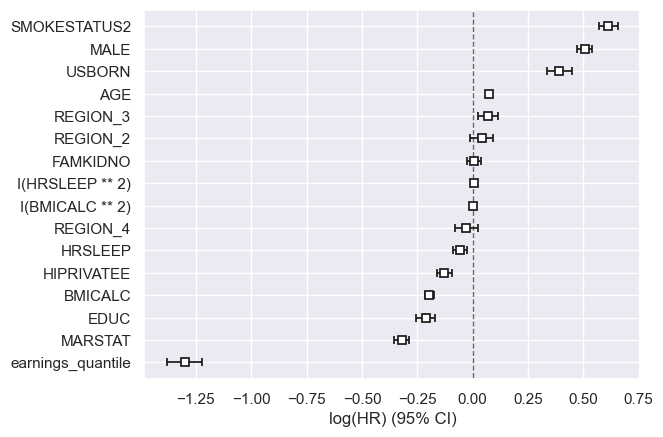

In [5]:
formula = (
    "AGE + "
    "BMICALC + I(BMICALC ** 2) + "
    "SMOKESTATUS2 + "
    "USBORN + "
    "HIPRIVATEE + "
    "HRSLEEP + I(HRSLEEP ** 2) + "
    "FAMKIDNO + "
    "MARSTAT + "
    "EDUC + "
    "earnings_quantile + "
    "REGION_2 + REGION_3 + REGION_4 + "
    "MALE"
)

dfp_nn_train, dfp_nn_test = train_test_split(dfp_nn, test_size=0.2, random_state=0)

start_time = time.time()
cph = CoxPHFitter()
cph.fit(dfp_nn_train, duration_col="time", event_col="event", formula=formula)
print(f"Fitting time: {time.time() - start_time:.2f} seconds")

cph.print_summary()
cph.plot();

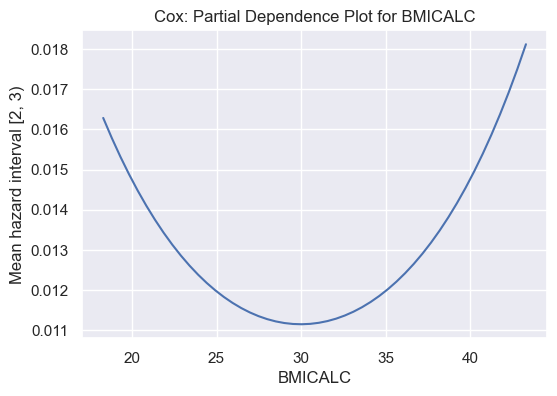

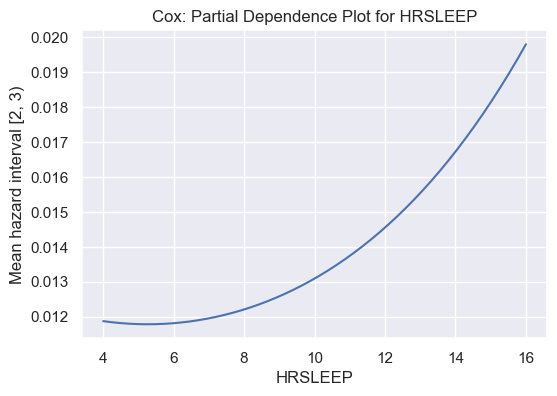

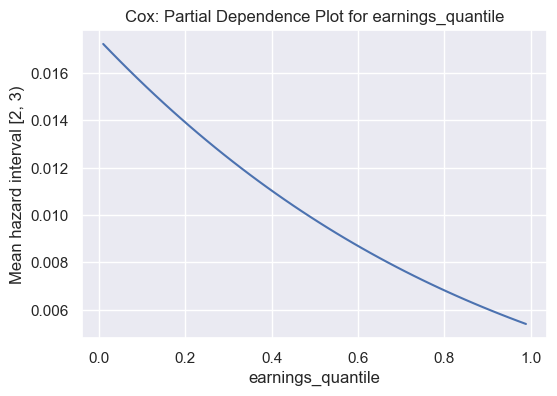

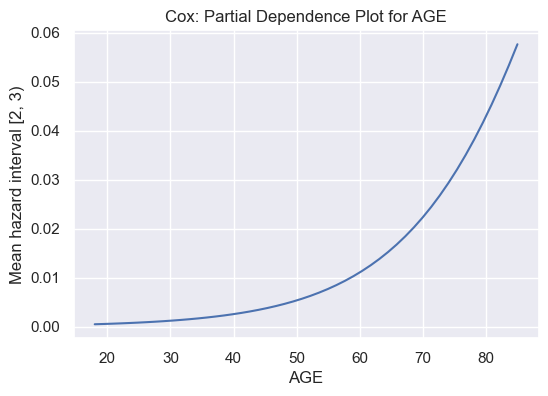

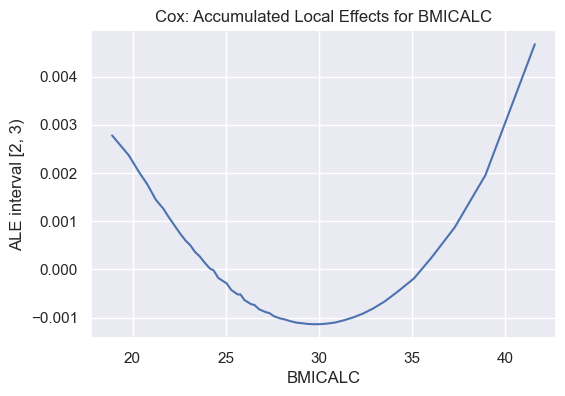

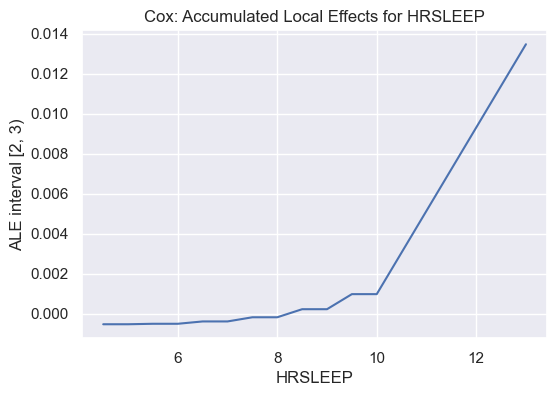

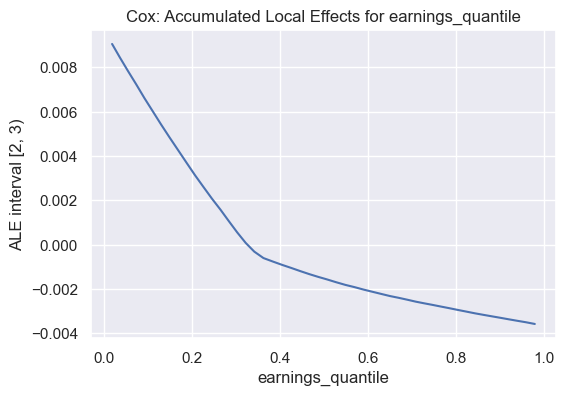

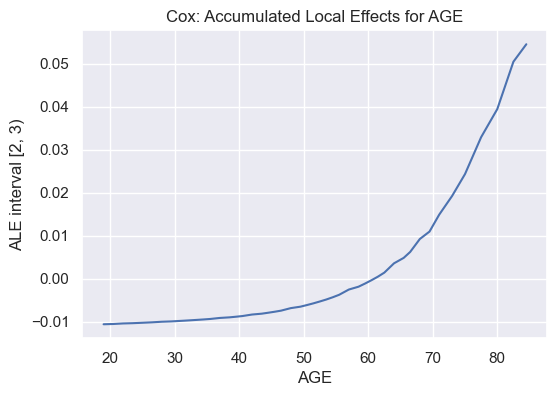

In [6]:
def plot_pdp(model, df, variable, t1, t2):
    x_vals = np.linspace(df[variable].quantile(0.01), df[variable].quantile(0.99), 50)
    y_vals = []
    for val in x_vals:
        df_copy = df.copy()
        df_copy[variable] = val
        pred_surv = model.predict_survival_function(df_copy).T.values
        y_vals.append((pred_surv[:,t1] - pred_surv[:,t2]).mean())
    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_vals)
    plt.xlabel(variable)
    plt.ylabel(f"Mean hazard interval [{t1}, {t2})")
    plt.title(f"Cox: Partial Dependence Plot for {variable}")
    plt.show()

def plot_ale(model, df, variable, t1, t2):
    df_sorted = df.sort_values(by=variable)
    quantiles = np.linspace(0.01, 0.99, 51)
    bin_edges = df[variable].quantile(quantiles).values
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    ale_values = []
    for i in range(len(bin_edges) - 1):
        lower, upper = bin_edges[i], bin_edges[i+1]
        mask = (df[variable] >= lower) & (df[variable] < upper)
        df_bin = df[mask]
        
        if df_bin.empty:
            ale_values.append(0.0)
            continue
        
        df_low = df_bin.copy()
        df_high = df_bin.copy()
        df_low[variable] = lower
        df_high[variable] = upper

        pred_surv_high = model.predict_survival_function(df_high).T.values
        pred_surv_low = model.predict_survival_function(df_low).T.values
        pred_diff = (pred_surv_high[:,t1] - pred_surv_high[:,t2]) - (pred_surv_low[:,t1] - pred_surv_low[:,t2])
        ale_values.append(np.mean(pred_diff))
    
    # Accumulate local effects
    ale_accumulated = np.cumsum(ale_values)
    ale_centered = ale_accumulated - np.mean(ale_accumulated)  # Centering
    
    plt.figure(figsize=(6, 4))
    plt.plot(bin_centers, ale_centered)
    plt.xlabel(variable)
    plt.ylabel(f"ALE interval [{t1}, {t2})")
    plt.title(f"Cox: Accumulated Local Effects for {variable}")
    plt.show()

for var in ["BMICALC", "HRSLEEP", "earnings_quantile", "AGE"]:
    plot_pdp(cph, dfp_nn_test, var, 2, 3)

for var in ["BMICALC", "HRSLEEP", "earnings_quantile", "AGE"]:
    plot_ale(cph, dfp_nn_test, var, 2, 3)

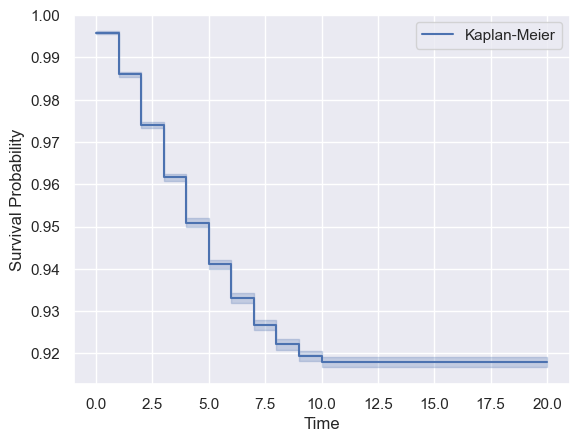

In [7]:
kmf = KaplanMeierFitter()
kmf.fit(dfp_nn_train["time"], dfp_nn_train["event"], label="Kaplan-Meier")
kmf.plot_survival_function()
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

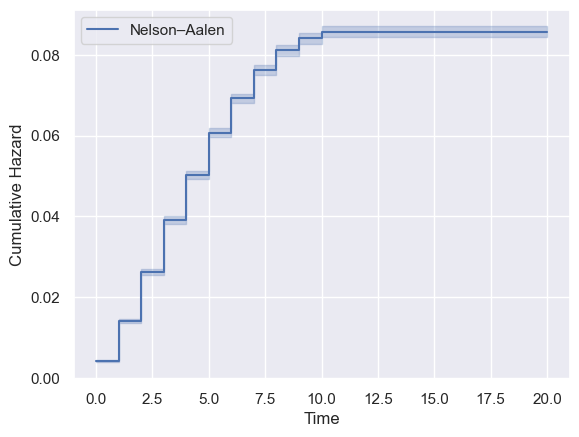

In [8]:
naf = NelsonAalenFitter()
naf.fit(dfp_nn_train["time"], dfp_nn_train["event"], label="Nelson–Aalen")
naf.plot()
plt.xlabel("Time")
plt.ylabel("Cumulative Hazard")
plt.show()

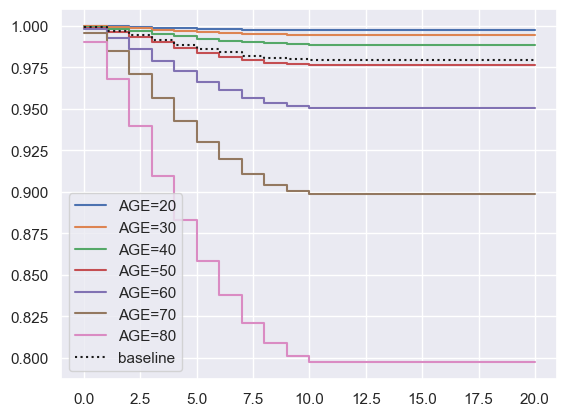

In [9]:
cph.plot_partial_effects_on_outcome(covariates='AGE', values=[20, 30, 40, 50, 60, 70, 80]);

In [10]:
# C-index
c_index = cph.concordance_index_
print(f"C-index: {c_index:.4f}")

# IBS
time_grid = np.arange(1, 10)
y_test = Surv.from_dataframe("event", "time", dfp_nn_test)
pred_surv = cph.predict_survival_function(dfp_nn_test, time_grid).T.values
ibs = integrated_brier_score(y_test, y_test, pred_surv, time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

# Log-loss
in_interval = ((dfp_nn_test["event"] == 1) & (dfp_nn_test["time"] >= 2) & (dfp_nn_test["time"] < 3)).astype(int)
p_interval = pred_surv[:,2] - pred_surv[:,3]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [2, 3): {logloss:.4f}")

C-index: 0.8612
Integrated Brier Score: 0.0417
Log loss for interval [2, 3): 0.0504


In [2]:
D2 = pd.read_csv("data/D2.csv")
D2["T"] = np.floor(D2["T"])
D2

,index,AGE,GENDER,BMI,SBP,TCL_HDL_RATIO,SD_SBP,NUM1,NUM2,NUM3,BINARY,mu,T,event,BMI_scaled,SBP_scaled,SD_SBP_scaled,TCL_HDL_RATIO_scaled
0,3,49,0,22.286183,110.748826,3.982616,11.923312,0.302983,0.807917,0.970089,0.0,0.022026,3.0,1,0.199357,0.019201,0.692331,0.329470
1,4,58,0,27.271473,126.547869,6.268732,6.155875,0.302030,0.977253,0.969042,1.0,0.411592,4.0,1,0.431231,0.424304,0.115587,0.837496
2,5,82,0,34.570903,122.837879,5.892966,8.646372,0.315338,0.068236,0.132202,1.0,0.596945,8.0,1,0.770740,0.329176,0.364637,0.753992
3,6,30,1,24.091885,113.584311,5.934155,6.951186,0.639465,0.513677,0.747794,1.0,0.006285,10.0,0,0.283344,0.091905,0.195119,0.763146
4,7,41,1,25.868334,118.341715,4.832708,6.096296,0.758591,0.533074,0.841474,1.0,0.011583,10.0,0,0.365969,0.213890,0.109630,0.518380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376390,1999992,22,0,19.408661,144.621608,5.794807,7.269997,0.884179,0.278386,0.409219,0.0,0.004659,10.0,0,0.065519,0.887734,0.227000,0.732179
1376391,1999994,72,1,26.498342,113.990817,4.531352,11.910375,0.085940,0.808494,0.030989,1.0,0.185639,10.0,0,0.395272,0.102329,0.691038,0.451412
1376392,1999996,7,1,24.351281,126.323347,5.333354,5.955099,0.119152,0.511268,0.939248,1.0,0.021910,10.0,0,0.295408,0.418547,0.095510,0.629634
1376393,1999997,1,0,24.670228,115.525113,6.083880,9.412671,0.370932,0.378601,0.258781,1.0,0.001430,10.0,0,0.310243,0.141670,0.441267,0.796418


/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Fitting time: 3.28 seconds


/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 1.10112e+06 total observations, 985193 right-censored observations>
             duration col = 'T'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1.10112e+06
number of events observed = 115923
   partial log-likelihood = -1450897.53
         time fit was run = 2025-08-28 09:44:11 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
AGE             0.10       1.10       0.00             0.10             0.10                 1.10                 1.10
BINARY          1.28       3.60       0.01             1.27             1.29                 3.55                 3.64
BMI            -0.06       0.95       0.01            -0.07            -0.05                 0.93                 0.96
GENDER         -0.37       0.69       0.01            -0.38            -0.36                 0.68                 0.70
I(BMI ** 2)     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
NUM1           -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
NUM2           -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
NUM3            1.78       5.96       0.01             1.76             1.81                 5.83                 6.09
SBP             0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
SD_SBP          0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
TCL_HDL_RATIO   0.18       1.20       0.00             0.18             0.19                 1.20                 1.21

                   z      p   -log2(p)
covariate                             
AGE           362.86 <0.005        inf
BINARY        188.78 <0.005        inf
BMI            -9.92 <0.005      74.58
GENDER        -62.46 <0.005        inf
I(BMI ** 2)     9.78 <0.005      72.60
NUM1           -1.24   0.22       2.22
NUM2           -0.13   0.89       0.16
NUM3          161.64 <0.005        inf
SBP            29.69 <0.005     641.05
SD_SBP          8.69 <0.005      57.93
TCL_HDL_RATIO  80.47 <0.005        inf
---
Concordance = 0.89
Partial AIC = 2901817.07
log-likelihood ratio test = 310951.83 on 11 df
-log2(p) of ll-ratio test = inf

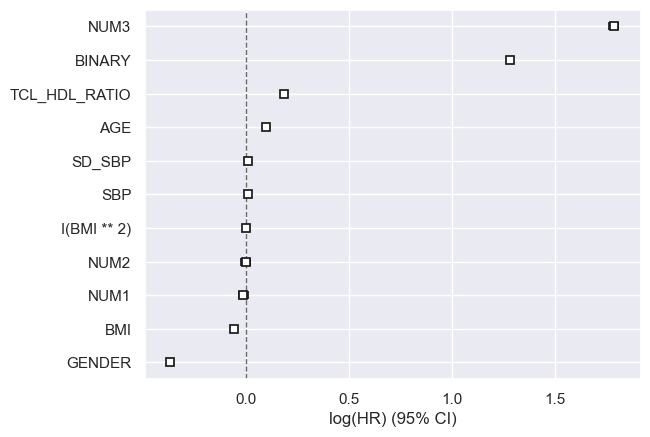

In [3]:
formula_D2 = (
    "AGE + "
    "BMI + I(BMI ** 2) + "
    "SBP + "
    "TCL_HDL_RATIO + "
    "SD_SBP + "
    "NUM1 + "
    "NUM2 + "
    "NUM3 + "
    "BINARY + "
    "GENDER"
)

D2_train, D2_test = train_test_split(D2, test_size=0.2, random_state=0)

start_time = time.time()
cph_D2 = CoxPHFitter()
cph_D2.fit(D2_train, duration_col="T", event_col="event", formula=formula_D2)
print(f"Fitting time: {time.time() - start_time:.2f} seconds")

cph_D2.print_summary()
cph_D2.plot();

In [15]:
# C-index
c_index = cph_D2.concordance_index_
print(f"C-index: {c_index:.4f}")

# IBS
time_grid = np.arange(1,10)
y_test = Surv.from_dataframe("event", "T", D2_test)
pred_surv = cph_D2.predict_survival_function(D2_test).T.values
ibs = integrated_brier_score(y_test, y_test, pred_surv[:,1:10], time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

# Log loss
in_interval = (D2_test["event"] == 1).astype(int)
p_interval = 1 - pred_surv[:,10]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [0, 10): {logloss:.4f}")

C-index: 0.8928
Integrated Brier Score: 0.0401
Log loss for interval [0, 10): 0.2039


In [14]:
pred = 1-pred_surv[:,10]
mse = np.mean(np.square(np.log(D2_test.mu) - np.log(pred)))
dev = -2*np.sum(D2_test.event*logit(pred) + np.log(1-pred))
kld = np.sum(D2_test.event*np.log(D2_test.event/pred))
print(f"MSE wrt log ground truth:    {mse:.4f}")
print(f"Logistic deviance:           {dev:.0f}")
print(f"Kullback-Leibler divergence: {kld:.0f}")

MSE wrt log ground truth:    1.7926
Logistic deviance:           112252
Kullback-Leibler divergence: 36282


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


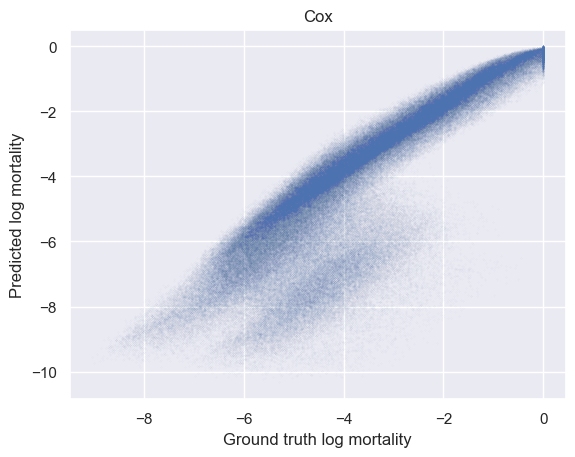

In [20]:
plt.plot(np.log(D2_test.mu), np.log(pred), '.', alpha=0.1, markersize=0.25)
plt.title("Cox")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")
plt.show()

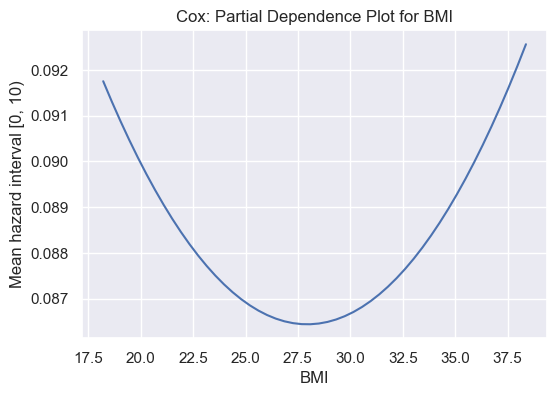

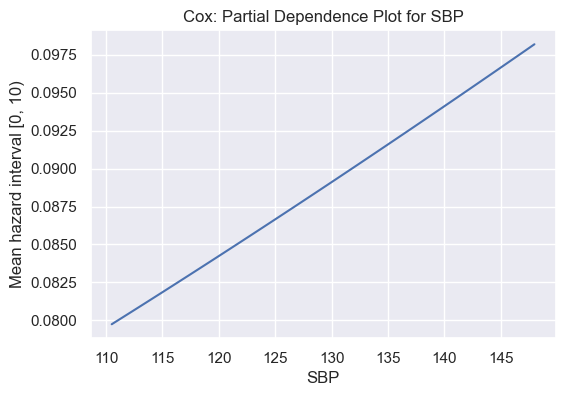

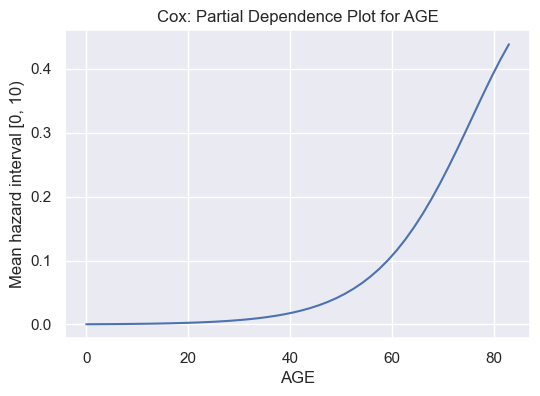

In [21]:
for var in ["BMI", "SBP", "AGE"]:
    plot_pdp(cph_D2, D2_test, var, 0, 10)

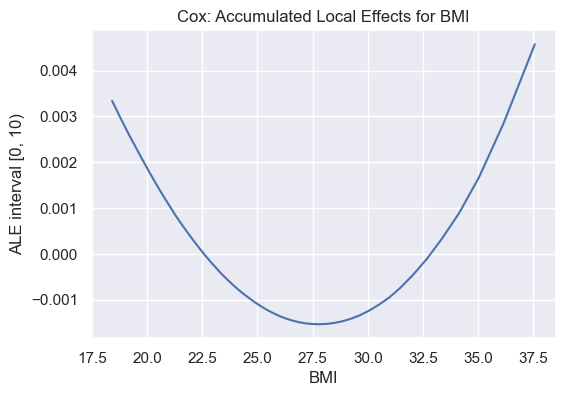

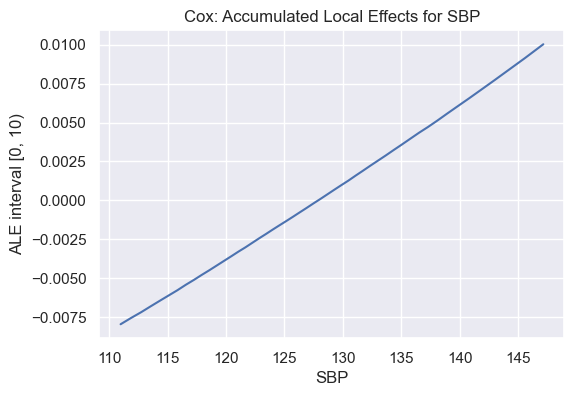

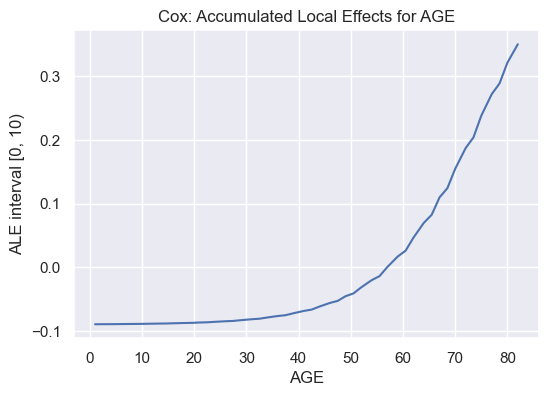

In [22]:
for var in ["BMI", "SBP", "AGE"]:
    plot_ale(cph_D2, D2_test, var, 0, 10)